In [7]:
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import itertools
import glob

0 P0-W0
(373, 504)
(373, 504)
1 P1-W1
(361, 504)
(361, 504)
2 P9-W7
(476, 504)
(476, 504)
3 P14-W0
(461, 504)
(461, 504)


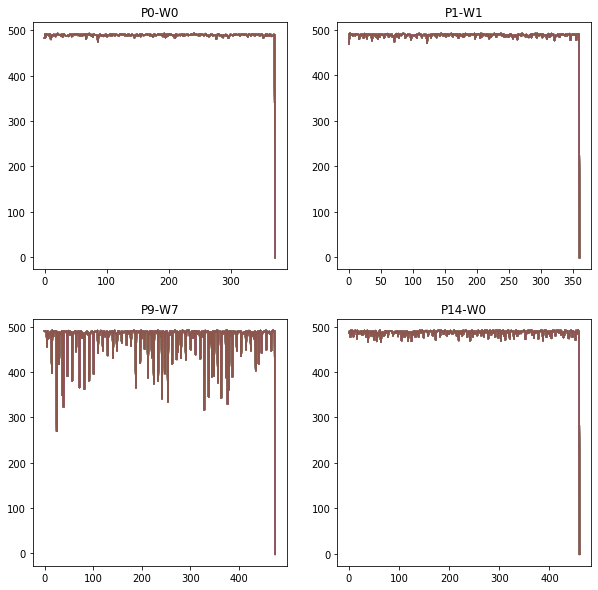

In [13]:
# Train Data = Difference

path = r'/home/giang/Lab/Code/Trainsets' # use your path
classes = {0:'P0-W0', 1:'P1-W1', 2:'P9-W7', 3:'P14-W0'}

df, x_np, y_np = {}, {}, {}
x_np_all, y_np_all = np.empty((0, 9, 56)), np.empty((0))

for i, cls in classes.items():
    print(i, cls)
    all_files = glob.glob(path + "/" + cls + "/*.csv")
    df[i] = pd.concat((pd.read_csv(f, header=None) for f in all_files))
    x_np[i] = np.transpose(np.array(df[i]))
    print(x_np[i].shape)
    
    for t in range(x_np[i].shape[0]-1):
        x_np[i][t,:] = np.correlate(x_np[i][t+1,:],x_np[i][t,:])
    print(x_np[i].shape)
#    x_np[i] = np.delete(x_np[i],-1,0)
    x_np[i] = x_np[i].reshape(-1,9,56)  # batch_size x channels x data
#    print(x_np[i].shape)

    y_np[i] = np.ones(len(x_np[i])) * i # Target label

    x_np_all = np.concatenate((x_np_all, x_np[i]), axis=0)
    y_np_all = np.concatenate((y_np_all, y_np[i]), axis=0)

# print(x_np_all.shape, y_np_all.shape)

# Visualize data sample
plt.figure(figsize=(10,10))
for i, cls in classes.items():
    plt.subplot(221 + i)
    plt.plot(x_np[i][:,1,:])
    #plt.xlabel("Subcarrier")
    #plt.ylabel("Amplitude")
    plt.title(cls)
plt.show()

# # Show 2D matrix as a grey image
# # Channel #1 [1,1]
# plt.imshow(x_np[0][:,0,:], cmap='Greys', interpolation='nearest')
# plt.show()
# # Channel #2 [1,2]
# plt.imshow(x_np[0][:,1,:], cmap='Greys', interpolation='nearest')
# plt.show()
# # Channel #2 [1,3]
# plt.imshow(x_np[0][:,2,:], cmap='Greys', interpolation='nearest')
# plt.show()

In [14]:
#Divdide and Load Data
data_length = x_np_all.shape[0]
data_id     = np.arange(0, data_length)
np.random.shuffle(data_id)

train_size = 0.5
train_id   = data_id[0:int(train_size*data_length)]
test_id    = data_id[int(train_size*data_length)::]

x_train     = x_np_all[train_id]
y_train     = y_np_all[train_id]
x_test      = x_np_all[test_id]
y_test      = y_np_all[test_id]

train = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train, batch_size = 50, shuffle = True,
                                          drop_last=True)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
# CNN Model
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 input shape=(?, 9, 56, 1)
        #    Conv     -> (?, 9, 56, 32)
        #    Pool     -> (?, 5, 28, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 input shape=(?, 5, 28, 32)
        #    Conv      ->(?, 5, 28, 64)
        #    Pool      ->(?, 3, 14, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 input shape=(?, 3, 14, 64)
        #    Conv      ->(?, 3, 14, 128)
        #    Pool      ->(?, 2, 8, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 2x8x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(2*8*128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2))
        # L5 Final FC 625 inputs -> 4 outputs
        self.fc2 = torch.nn.Linear(625, 4, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

model = CNN().to(device)

In [17]:
#Parameters
training_epochs = 100

criterion = torch.nn.CrossEntropyLoss().to(device)  

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#optimizer = torch.optim.Adamax(model.parameters(), lr=0.1)

# 학습
model.train()

for epoch in range(training_epochs):

    avg_cost = 0
    total_batch = len(train_loader)

    for X, T in train_loader:
        #X = X.view(-1, 56).to(device)
        #X = X.view(-1, 9*56).to(device)  # MLP
        X = X.view(-1, 1, 9, 56).to(device)  # CNN
        T = T.to(device)
        #T = T.type(torch.LongTensor)


        optimizer.zero_grad()   # 기존 계산한 경사값 삭제
        output = model(X)       # 순방향 연산
        cost = criterion(output, T)   # 손실함수 설정
        cost.backward()         # 경사값 계산
        optimizer.step()        # 업데이트 1회 수행

        avg_cost += cost / total_batch     # 평균 손실함수값 계산

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
    
print('Learning finished')

Epoch: 0001 cost = nan
Epoch: 0002 cost = nan
Epoch: 0003 cost = nan
Epoch: 0004 cost = nan
Epoch: 0005 cost = nan
Epoch: 0006 cost = nan
Epoch: 0007 cost = nan
Epoch: 0008 cost = nan
Epoch: 0009 cost = nan
Epoch: 0010 cost = nan
Epoch: 0011 cost = nan
Epoch: 0012 cost = nan
Epoch: 0013 cost = nan
Epoch: 0014 cost = nan
Epoch: 0015 cost = nan
Epoch: 0016 cost = nan
Epoch: 0017 cost = nan
Epoch: 0018 cost = nan
Epoch: 0019 cost = nan
Epoch: 0020 cost = nan
Epoch: 0021 cost = nan
Epoch: 0022 cost = nan
Epoch: 0023 cost = nan
Epoch: 0024 cost = nan
Epoch: 0025 cost = nan
Epoch: 0026 cost = nan
Epoch: 0027 cost = nan
Epoch: 0028 cost = nan
Epoch: 0029 cost = nan
Epoch: 0030 cost = nan
Epoch: 0031 cost = nan
Epoch: 0032 cost = nan
Epoch: 0033 cost = nan
Epoch: 0034 cost = nan
Epoch: 0035 cost = nan
Epoch: 0036 cost = nan
Epoch: 0037 cost = nan
Epoch: 0038 cost = nan
Epoch: 0039 cost = nan
Epoch: 0040 cost = nan
Epoch: 0041 cost = nan
Epoch: 0042 cost = nan
Epoch: 0043 cost = nan
Epoch: 0044

In [18]:
# Accuracy With Train Data
with torch.no_grad():
    model.eval()
    
    X_test = torch.Tensor(x_test).to(device)
    T_test = torch.Tensor(y_test).to(device)

    # 테스트셋에 대해 추론 수행
    #output = model(X_test.view(-1, 9*56))  # MLP
    output = model(X_test.view(-1, 1, 9, 56))  # CNN


    # 출력값이 가장 높은 뉴런의 인덱스와 정답을 비교, 맞으면 1, 틀리면 0
    correct_prediction = torch.argmax(output, 1) == T_test

    # 정확도 계산
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.21531100571155548


Label:  0 (P0-W0)
Prediction:  0


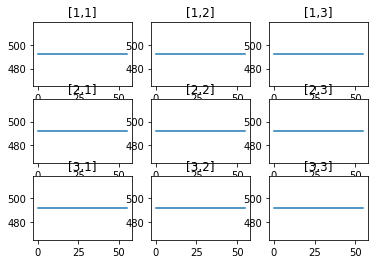

In [20]:
#Test With Train Data
with torch.no_grad():
    # 테스트셋 중에 임의로 하나를 선택
    r = random.randint(0, len(x_test) - 1)    
    X_single_data = torch.Tensor(x_test[r,:,:]).float().to(device)
    T_single_data = y_test[r]

    print('Label: ', '%d' % T_single_data.item(), '({})'.format(classes[T_single_data.item()]))
    #single_output = model(X_single_data.view(-1, 9*56))  # MLP
    single_output = model(X_single_data.view(-1, 1, 9, 56))  # CNN
    print('Prediction: ', torch.argmax(single_output, 1).item())


# 전체 안테나페어 CSI 플롯팅    
for i in range(9):
    plt.subplot(331 + i)
    plt.plot(x_test[r,i,:])
    #plt.xlabel("Subcarrier")
    #plt.ylabel("Amplitude")
    plt.title("[" + str(i//3+1) + "," + str(i%3+1) + "]")

plt.show()

In [22]:
#Load Test Data
path = r'/home/giang/Lab/Code/TestSets' # use your path
classest = {0:'P0-W0', 1:'P1-W1', 2:'P9-W7', 3:'P14-W0'}

dft, x_npt, y_npt = {}, {}, {}
x_npt_all, y_npt_all = np.empty((0, 9, 56)), np.empty((0))

for i, cls in classest.items():
    print(i, cls)
    all_filest = glob.glob(path + "/" + cls + "/*.csv")
    dft[i] = pd.concat((pd.read_csv(f, header=None) for f in all_filest))
    x_npt[i] = np.transpose(np.array(dft[i]))
    print(x_npt[i].shape)

    for t in range(x_npt[i].shape[0]-1):
        x_npt[i][t,:] = x_npt[i][t+1,:]-x_npt[i][t,:]
    
    x_npt[i] = np.delete(x_npt[i],-1,0)  
    x_npt[i] = x_npt[i].reshape(-1,9,56)  # batch_size x channels x data
    print(x_npt[i].shape)

    y_npt[i] = np.ones(len(x_npt[i])) * i # Target label

    x_npt_all = np.concatenate((x_npt_all, x_npt[i]), axis=0)
    y_npt_all = np.concatenate((y_npt_all, y_npt[i]), axis=0)


test = torch.utils.data.TensorDataset(torch.Tensor(x_npt_all), torch.Tensor(y_npt_all).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(test, batch_size = 50, shuffle = True, drop_last =True)

0 P0-W0
(861, 504)
(860, 9, 56)
1 P1-W1
(743, 504)
(742, 9, 56)
2 P9-W7
(819, 504)
(818, 9, 56)
3 P14-W0
(824, 504)
(823, 9, 56)


Accuracy: 0.2651865482330322
tensor([[846,   0,   0,   0],
        [731,   0,   0,   0],
        [809,   0,   0,   0],
        [814,   0,   0,   0]])


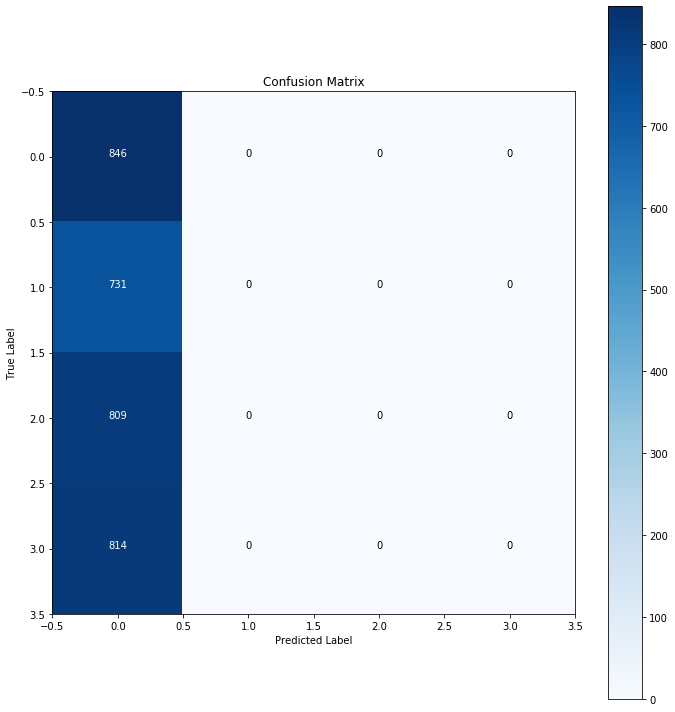

In [23]:
# Test Accuracy
with torch.no_grad():
    model.eval()
    
    Xt_test = torch.Tensor(x_npt_all).to(device)
    Yt_test = torch.Tensor(y_npt_all).to(device)
    # 테스트셋에 대해 추론 수행
   
    outputtest = model(Xt_test.view(-1, 1, 9, 56))  # CNN


    # 출력값이 가장 높은 뉴런의 인덱스와 정답을 비교, 맞으면 1, 틀리면 0
    correct_prediction = torch.argmax(outputtest, 1) == Yt_test

    # 정확도 계산
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

#Confusion Matrix
    all_targetstest = torch.tensor([]).long()
    all_predstest = torch.tensor([])
    
    for X, T in test_loader:
        X = X.view(-1, 1, 9, 56)
        predstest = model(X)
        all_predstest = torch.cat((all_predstest,predstest), dim=0)
        all_targetstest = torch.cat((all_targetstest,T), dim=0)
    #print(all_predstest.shape)
    #print(all_targetstest.shape)
    
    stackedtest = torch.stack((all_targetstest,all_predstest.argmax(dim=1)),dim=1)
    #print(stackedtest.shape)
    
    cfmattest = torch.zeros(4,4, dtype=torch.int64)
    for p in stackedtest:
        train, pred = p.tolist()
        cfmattest[train, pred] = cfmattest[train, pred] + 1
    print(cfmattest)
    
    plt.figure(figsize=(10,10))
    plt.imshow(cfmattest, interpolation = 'nearest', cmap = 'Blues')
    #tick_marks = np.arange(len(classes.values()))
    #plt.xticks(tick_marks, classes.values(), verticalalignment = 'center')
    #plt.yticks(tick_marks, classes.values())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.colorbar()
    for i, j in itertools.product(range(cfmattest.shape[0]), range(cfmattest.shape[1])):
            plt.text(j, i, format(cfmattest[i, j], 'd')
                     , horizontalalignment="center"
                     , color="white" if cfmattest[i, j] > (cfmattest.max()/2) else "black")
    plt.tight_layout()